In [1]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import (
    get_linear_interpolants,get_trig_interpolants,
    root_prod_gamma,root_prod_gammadot,
    get_loss_functions
)
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model
from stochastic_interpolant.sampler import StochasticSampler
plt.style.use('ggplot')

In [66]:
def setup_2d_stochastic_interpolant(
    target_samples,
):
    I,It = get_linear_interpolants()
    gamma = root_prod_gamma
    gammadot = root_prod_gammadot
    loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

    b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,1024,256], 
    key = jax.random.PRNGKey(21239)
    )

    eta_model = NeuralNetwork(
        input_size = 3,
        output_size=2,
        layer_sizes = [256,1024,256], 
        key = jax.random.PRNGKey(30238)
    )
    data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )
    batch_size = 1024
    train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
    test_factory = testloader_factory(batch_size,jax.random.PRNGKey(32498130),data_coupling_sampler)

    return b_model,loss_b,eta_model,loss_denoise,train_loader,test_factory,gamma

def train_models(
        b_model,
        eta_model,
        loss_b,
        loss_denoise,
        train_loader,
        test_factory,
):
    """
    Trains with our default hyperparameters
    """
    learning_rate = 4e-3
    num_steps = 10000

    scheduler = optax.piecewise_constant_schedule(
    learning_rate,
    {
        5000:0.25,
        20000:0.25,
        50000:0.1,
        80000:0.5
    }
    )

    grad_clip = optax.adaptive_grad_clip(0.5, eps=0.001)
    b_optim = optax.chain(
        grad_clip,
        optax.nadamw(learning_rate)
    )

    b_model,b_loss_history = train_model(
    model = b_model,
    optim = b_optim,
    steps = num_steps,
    train_loader = train_loader,
    testloader_factory = test_factory,
    loss_fun = loss_b,
    print_every = num_steps//10,
    num_testloader_batches = 100,
    )

    grad_clip = optax.adaptive_grad_clip(0.5, eps=0.001)
    eta_optim = optax.chain(
        grad_clip,
        optax.nadamw(learning_rate)
    )

    eta_model,eta_loss_history = train_model(
    model = eta_model,
    optim = eta_optim,
    steps = num_steps,
    train_loader = train_loader,
    testloader_factory = test_factory,
    loss_fun = loss_denoise,
    print_every = num_steps//10,
    num_testloader_batches = 100,
    )
    return b_model,b_loss_history,eta_model,eta_loss_history
from diffrax import SaveAt

def sample_plot_trajectories(
        stoch_sampler,
        test_set,
        eps,
        fig_save = None,
        num_trajectories = 20,
        ):
    X0 = jax.random.normal(jax.random.PRNGKey(13334),(10000,2))
    saveat = SaveAt(
        ts = jnp.linspace(0,1.,5),
        dense = False
    )
    X,sol = stoch_sampler.sample_trajectory(X0,eps = eps,saveat = saveat,dt0 = 1e-3)
    
    time_points = np.linspace(0,1,500)
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0],X[:,1],alpha = 0.05,c='blue')
    MMD_val = MMD(X,test_set)
    plt.title(f"eps = {eps}, test MMD = {MMD_val:.3}")
                  
    if fig_save is not None:
        plt.savefig(fig_save + f"eps_{eps}.png")

    saveat = SaveAt(
        dense = True
    )
    X,sol = stoch_sampler.sample_trajectory(X0[:num_trajectories],eps = eps,saveat = saveat,dt0 = 1e-3)
    path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
    for i in range(len(path[0])):
        plt.plot(path[:,i,0],path[:,i,1],alpha = 0.8,c='red')

    plt.scatter(X0[:num_trajectories,0],X0[:num_trajectories,1],c = 'black',s = 20.,label = "t=0")
    plt.scatter(X[:num_trajectories,0],X[:num_trajectories,1],c = 'blue',s = 20.,label = "t=1")
    plt.legend()
    plt.savefig(fig_save + f"eps_{eps}_trajectories.png")
    plt.close()
    return MMD_val

sigma = 0.25
def k_single(x,y):
    return jnp.exp(-jnp.sqrt(jnp.sum(x-y)**2/(2*sigma**2)))
def vectorize_kfunc(k):
    return jax.vmap(jax.vmap(k, in_axes=(None,0)), in_axes=(0,None))
k = vectorize_kfunc(k_single)

@jax.jit
def MMD(X,Y):
    return jnp.mean(k(X,X)) +jnp.mean(k(Y,Y)) - 2 * jnp.mean(k(X,Y))

def get_ma(x,k = 100):
    ma = jnp.cumsum(x)
    return (ma[k:] - ma[:-k])/k


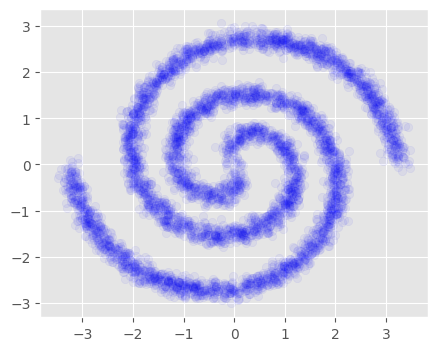

  0%|          | 0/10000 [00:00<?, ?it/s]

step=0 | train_loss=-0.024362843 | test_loss= 42.16767
step=1000 | train_loss=-1.2324584 | test_loss= -1.151345
step=2000 | train_loss=-1.4731214 | test_loss= -1.3271862
step=3000 | train_loss=-1.4821075 | test_loss= -1.3883343
step=4000 | train_loss=-1.4351482 | test_loss= -1.4351385
step=5000 | train_loss=-1.5022347 | test_loss= -1.4946946
step=6000 | train_loss=-1.7154633 | test_loss= -1.507744
step=7000 | train_loss=-1.9356705 | test_loss= -1.541293
step=8000 | train_loss=-1.7940727 | test_loss= -1.36806
step=9000 | train_loss=-1.2115834 | test_loss= -1.5890617
step=9999 | train_loss=-1.7645731 | test_loss= -1.3522133


  0%|          | 0/10000 [00:00<?, ?it/s]

step=0 | train_loss=0.022350548 | test_loss= 45.951443
step=1000 | train_loss=-0.5200671 | test_loss= -0.51751935
step=2000 | train_loss=-0.48056972 | test_loss= -0.5174452
step=3000 | train_loss=-0.5221293 | test_loss= -0.52483785
step=4000 | train_loss=-0.460635 | test_loss= -0.528041
step=5000 | train_loss=-0.5683224 | test_loss= -0.5285651
step=6000 | train_loss=-0.5347973 | test_loss= -0.5239985
step=7000 | train_loss=-0.48545942 | test_loss= -0.5338824
step=8000 | train_loss=-0.61092776 | test_loss= -0.5279008
step=9000 | train_loss=-0.52309066 | test_loss= -0.530748
step=9999 | train_loss=-0.5567053 | test_loss= -0.5273865


In [37]:
example_name = '2spirals'

num_target = 5000
target_samples = inf_train_gen(example_name,rng = 50,batch_size = num_target)
plt.figure(figsize=(5,4))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.05,c='blue')
plt.savefig(f"all_figures/{example_name}.png")
plt.show()

b_model,loss_b,eta_model,loss_denoise,train_loader,test_factory,gamma = setup_2d_stochastic_interpolant(target_samples=target_samples)

b_model,b_loss_history,eta_model,eta_loss_history = train_models(
    b_model,
    eta_model,
    loss_b,
    loss_denoise,
    train_loader,
    test_factory,
)

plt.plot(get_ma(eta_loss_history,1000)[20:])
plt.title("eta loss train MA 1000")
plt.savefig(f"all_figures/{example_name}_eta_loss.png")
plt.close()
plt.plot(get_ma(b_loss_history,1000)[20:])
plt.title("b loss train MA 1000")
plt.savefig(f"all_figures/{example_name}_b_loss.png")
plt.close()


stochastic_sampler = StochasticSampler(gamma,b_model,eta_model)
eps_vals = [0,1e-3,0.025,0.1,0.25,0.5,1.,2.,3.,5.,10.,15.,25.]

target_resample = inf_train_gen(example_name,rng = 50,batch_size = 10000)

mmd_errors = []
for eps in eps_vals:
    print(eps)
    mmd_errors.append(sample_plot_trajectories(stochastic_sampler,target_resample,eps,f'all_figures/{example_name}_'))

jnp.save(f"all_figures/{example_name}_mmd.npy",jnp.vstack([jnp.array(eps_vals),jnp.array(mmd_errors)]).T)
plt.plot(eps_vals,mmd_errors)
plt.xscale('log')
plt.xlabel("eps")
plt.ylabel("MMD")
plt.title(f"{example_name} MMD for different diffusion levels")
plt.savefig(f"all_figures/{example_name}_mmd.png")
plt.close()

0
0.025
0.1
0.25
0.5
1.0
2.0
3.0
5.0
10.0
15.0
25.0


In [88]:
example_name = 'checkerboard'

num_target = 5000
target_samples = inf_train_gen(example_name,batch_size = num_target)


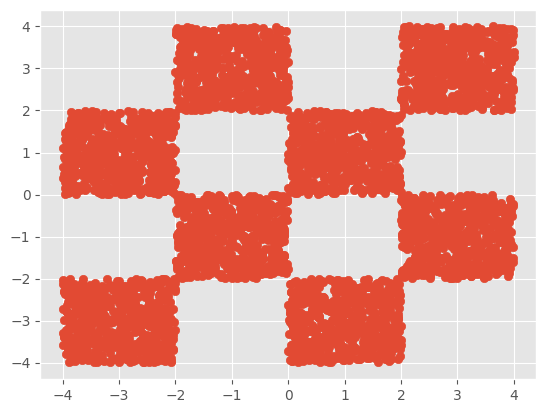

: 

In [89]:
plt.scatter(target_samples[:,0],target_samples[:,1])